In [1]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats
import io
import os
from pathlib import Path

plt.rcParams['figure.dpi'] = 100
print('✓ Packages imported')

✓ Packages imported


In [2]:
# Define color palette (color-blind friendly gradient: purple to teal)
PALETTE = {
    'purple_deep': '#7d22d3',
    'purple': '#5e34da',
    'blue_dark': '#3e46e0',
    'blue': '#3586df',
    'cyan': '#2cc5dd',
    'cyan_light': '#2cddc8',
    'teal': '#26cf9e',
    'teal_bright': '#1fc173'
}

COLOR_PRIMARY = PALETTE['purple_deep']    # Deep purple
COLOR_SECONDARY = PALETTE['teal_bright']  # Bright teal

# Create custom colormap for heatmaps
colors_list = ['#7d22d3', '#5e34da', '#3e46e0', '#3586df', '#2cc5dd', '#2cddc8', '#26cf9e', '#1fc173']
custom_cmap = LinearSegmentedColormap.from_list('palette_cmap', colors_list)

print(f'✓ Color palette loaded: {len(PALETTE)} colors')
print(f'  Primary: {COLOR_PRIMARY}, Secondary: {COLOR_SECONDARY}')

✓ Color palette loaded: 8 colors
  Primary: #7d22d3, Secondary: #1fc173


In [3]:
# Styling function for consistent plot appearance
def style_plot(ax):
    """Apply consistent styling: remove spines, add pale gray grid, set font."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.grid(True, color='#E5E5E5', linestyle='-', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)
    try:
        plt.rcParams['font.family'] = 'Montserrat'
    except:
        plt.rcParams['font.family'] = 'sans-serif'

print('✓ Styling function loaded')

✓ Styling function loaded


In [4]:
# Statistical utility functions
def _cohen_d(x, y):
    """Calculate Cohen's d effect size."""
    x = np.asarray(x)
    y = np.asarray(y)
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    sx = x.std(ddof=1)
    sy = y.std(ddof=1)
    pooled = np.sqrt(((nx-1)*sx*sx + (ny-1)*sy*sy) / (nx+ny-2))
    if pooled == 0:
        return np.nan
    return (x.mean() - y.mean()) / pooled

def pvalue_to_stars(p):
    """Convert p-value to significance stars."""
    if np.isnan(p):
        return ''
    if p < 0.001:
        return '***'
    if p < 0.01:
        return '**'
    if p < 0.05:
        return '*'
    return 'ns'

def annotate_ax_with_stats(ax, text):
    """Add statistics text annotation to plot."""
    ax.text(0.98, 0.98, text, 
            transform=ax.transAxes, 
            verticalalignment='top', 
            horizontalalignment='right',
            fontsize=9,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

print('✓ Statistical utility functions loaded')

✓ Statistical utility functions loaded


In [5]:
# Dummy data generator
def generate_dummy_metrics(feature='mitochondria', n_objects=150, seed=42):
    """
    Generate synthetic metrics for visualization testing.
    
    Args:
        feature: 'mitochondria', 'nuclei', or 'membrane'
        n_objects: Number of objects to generate
        seed: Random seed for reproducibility
    
    Returns:
        DataFrame with columns: area, perimeter, eccentricity, solidity, 
                                mean_intensity, centroid_x, centroid_y
    """
    np.random.seed(seed)
    
    if feature == 'mitochondria':
        areas = np.random.lognormal(mean=4.5, sigma=1.2, size=n_objects)
        eccentricities = np.random.beta(8, 2, size=n_objects)
        solidities = np.random.beta(5, 2, size=n_objects)
        intensities = np.random.normal(150, 12, size=n_objects)
    elif feature == 'nuclei':
        areas = np.random.lognormal(mean=7.5, sigma=0.8, size=n_objects)
        eccentricities = np.random.beta(2, 8, size=n_objects)
        solidities = np.random.beta(8, 2, size=n_objects)
        intensities = np.random.normal(120, 10, size=n_objects)
    elif feature == 'membrane':
        areas = np.random.lognormal(mean=3.0, sigma=1.5, size=n_objects)
        eccentricities = np.random.beta(9, 1, size=n_objects)
        solidities = np.random.beta(3, 3, size=n_objects)
        intensities = np.random.normal(180, 15, size=n_objects)
    else:
        raise ValueError(f"Unknown feature: {feature}")
    
    perimeters = np.sqrt(areas) * 4 * (1 + 0.2 * np.random.randn(n_objects))
    centroid_x = np.random.uniform(0, 1024, size=n_objects)
    centroid_y = np.random.uniform(0, 1024, size=n_objects)
    
    df = pd.DataFrame({
        'area': areas,
        'perimeter': perimeters,
        'eccentricity': eccentricities,
        'solidity': solidities,
        'mean_intensity': intensities,
        'centroid_x': centroid_x,
        'centroid_y': centroid_y
    })
    
    return df

print('✓ Dummy data generator loaded')

✓ Dummy data generator loaded


In [6]:
# Visualization functions

def plot_size_distribution(df, feature_name='organelle', bins=30, return_png=False):
    """Create size distribution plots (histogram + boxplot)."""
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Histogram
    axes[0].hist(df['area'], bins=bins, alpha=0.7, color=COLOR_PRIMARY)
    axes[0].set_xlabel('Area (px²)')
    axes[0].set_ylabel('Count')
    axes[0].set_xscale('log')
    axes[0].set_title(f'{feature_name.capitalize()} Size Distribution')
    style_plot(axes[0])
    
    # Boxplot
    axes[1].boxplot(df['area'], vert=True)
    axes[1].set_ylabel('Area (px²)')
    axes[1].set_yscale('log')
    axes[1].set_title(f'{feature_name.capitalize()} Area Boxplot')
    style_plot(axes[1])
    
    plt.tight_layout()
    
    if return_png:
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close()
        return buf.getvalue()
    
    plt.show()
    return None


def plot_shape_analysis(df, feature_name='organelle', return_png=False):
    """Create area vs eccentricity scatter plot with marginal histograms."""
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Main scatter
    axes[0].scatter(df['area'], df['eccentricity'], alpha=0.6, s=20, color=COLOR_PRIMARY)
    axes[0].set_xlabel('Area (px²)')
    axes[0].set_ylabel('Eccentricity')
    axes[0].set_xscale('log')
    axes[0].set_title(f'{feature_name.capitalize()} Shape Analysis')
    style_plot(axes[0])
    
    # Eccentricity histogram
    axes[1].hist(df['eccentricity'], bins=30, orientation='horizontal', color=COLOR_PRIMARY, alpha=0.7)
    axes[1].set_xlabel('Count')
    axes[1].set_ylabel('Eccentricity')
    axes[1].set_title('Eccentricity Distribution')
    style_plot(axes[1])
    
    plt.tight_layout()
    
    if return_png:
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close()
        return buf.getvalue()
    
    plt.show()
    return None


def plot_spatial_distribution(df, feature_name='organelle', return_png=False):
    """Create centroid scatter and density heatmap."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scatter plot
    axes[0].scatter(df['centroid_x'], df['centroid_y'], alpha=0.5, s=10, color=COLOR_SECONDARY)
    axes[0].set_xlabel('X (px)')
    axes[0].set_ylabel('Y (px)')
    axes[0].set_title(f'{feature_name.capitalize()} Centroid Positions')
    axes[0].invert_yaxis()
    style_plot(axes[0])
    
    # Density heatmap
    h = axes[1].hist2d(df['centroid_x'], df['centroid_y'], bins=20, cmap=custom_cmap)
    plt.colorbar(h[3], ax=axes[1], label='Count')
    axes[1].set_xlabel('X (px)')
    axes[1].set_ylabel('Y (px)')
    axes[1].set_title(f'{feature_name.capitalize()} Density Heatmap')
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    
    if return_png:
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close()
        return buf.getvalue()
    
    plt.show()
    return None


def plot_violin_for_metric(dfs, labels=None, metric='area', return_png=False, show_stats=True):
    """Create violin plots comparing metric across datasets."""
    if labels is None:
        labels = [f"{i}" for i in range(len(dfs))]
    
    data = [df[metric].dropna() for df in dfs]
    fig, ax = plt.subplots(figsize=(6, 4))
    parts = ax.violinplot(data, showmeans=False, showmedians=True)
    
    # Color the violin bodies
    colors = [COLOR_PRIMARY, COLOR_SECONDARY] if len(dfs) >= 2 else [COLOR_PRIMARY]
    for j, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[j % len(colors)])
        pc.set_alpha(0.7)
    
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_ylabel(metric)
    style_plot(ax)
    
    # Add statistics for two-group comparison
    if show_stats and len(dfs) == 2:
        try:
            u_stat, u_p = stats.mannwhitneyu(data[0], data[1], alternative='two-sided')
        except Exception:
            u_p = np.nan
        d = _cohen_d(data[0], data[1])
        txt = f"MWU p={u_p:.3g} {pvalue_to_stars(u_p)}\nCohen d={d:.2f}"
        annotate_ax_with_stats(ax, txt)
    
    plt.tight_layout()
    
    if return_png:
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close()
        return buf.getvalue()
    
    plt.show()
    return None


def plot_histograms_metric_for_two_dfs(df1, df2, labels=('A', 'B'), metric='area', bins=30, return_png=False, show_stats=True):
    """Create overlaid histograms comparing metric between two datasets."""
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(df1[metric].dropna(), bins=bins, alpha=0.6, label=labels[0], color=COLOR_PRIMARY)
    ax.hist(df2[metric].dropna(), bins=bins, alpha=0.6, label=labels[1], color=COLOR_SECONDARY)
    ax.set_xlabel(metric if metric != 'area' else 'Area (log scale)')
    if metric == 'area':
        ax.set_xscale('log')
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_title(f"{metric} comparison: {labels[0]} vs {labels[1]}")
    style_plot(ax)
    
    # Add statistics
    if show_stats:
        try:
            ks_stat, ks_p = stats.ks_2samp(df1[metric].dropna(), df2[metric].dropna())
        except Exception:
            ks_p = np.nan
        try:
            u_stat, u_p = stats.mannwhitneyu(df1[metric].dropna(), df2[metric].dropna(), alternative='two-sided')
        except Exception:
            u_p = np.nan
        d = _cohen_d(df1[metric].dropna(), df2[metric].dropna())
        txt = f"KS p={ks_p:.3g} {pvalue_to_stars(ks_p)}\nMWU p={u_p:.3g} {pvalue_to_stars(u_p)}\nCohen d={d:.2f}"
        annotate_ax_with_stats(ax, txt)
    
    plt.tight_layout()
    
    if return_png:
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close()
        return buf.getvalue()
    
    plt.show()
    return None

print('✓ Visualization functions loaded')

✓ Visualization functions loaded


## Usage Examples

### Example 1: Single Feature Analysis

In [7]:
# Generate dummy mitochondria data
df_mito = generate_dummy_metrics('mitochondria', n_objects=300, seed=42)

print(f"Generated {len(df_mito)} mitochondria objects")
print("\nFirst few rows:")
display(df_mito.head())

print("\nBasic statistics:")
display(df_mito.describe())

Generated 300 mitochondria objects

First few rows:


,area,perimeter,eccentricity,solidity,mean_intensity,centroid_x,centroid_y
0,163.376440,50.783812,0.842817,0.676912,140.840567,514.485542,412.368610
1,76.254989,38.106428,0.806740,0.729515,150.455254,749.042032,688.647437
2,195.825948,50.193687,0.867412,0.369700,158.199948,981.112841,698.564290
3,559.831490,90.924195,0.775265,0.466541,147.488234,225.736708,322.805181
4,67.966569,31.619021,0.875200,0.792583,162.875737,907.450135,136.406962



Basic statistics:


,area,perimeter,eccentricity,solidity,mean_intensity,centroid_x,centroid_y
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,200.757991,43.601233,0.795911,0.717467,151.111665,504.180810,497.128224
std,581.220522,32.517829,0.113830,0.151289,12.006657,299.198482,289.663604
min,1.841314,4.874375,0.461359,0.282874,118.371027,0.031456,4.287942
25%,39.651438,24.248874,0.728857,0.620198,142.503860,254.474083,231.673670
50%,96.646896,36.440965,0.812053,0.732579,151.313351,513.385381,498.404667
75%,190.946138,53.657981,0.882597,0.831416,158.505246,749.732007,709.010890
max,9166.197289,391.060954,0.986709,0.992192,185.823108,1019.462554,1021.695374


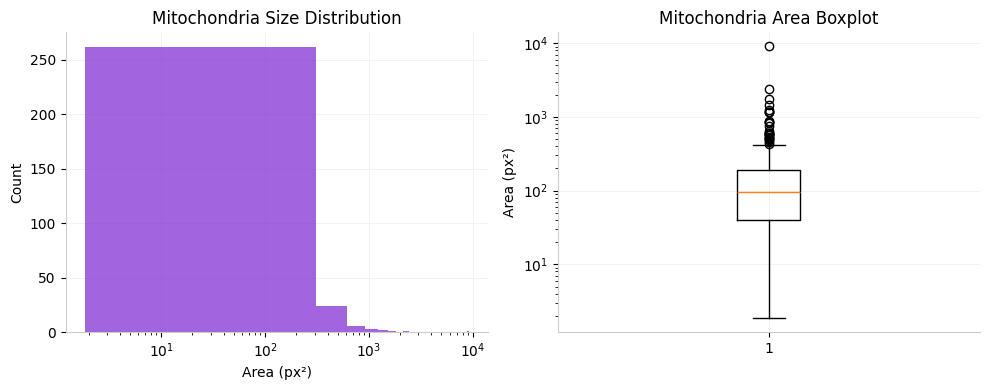

In [8]:
# Plot size distribution
plot_size_distribution(df_mito, feature_name='mitochondria')

findfont: Font family 'Montserrat' not found.
findfont: Font family ['Montserrat'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
fin

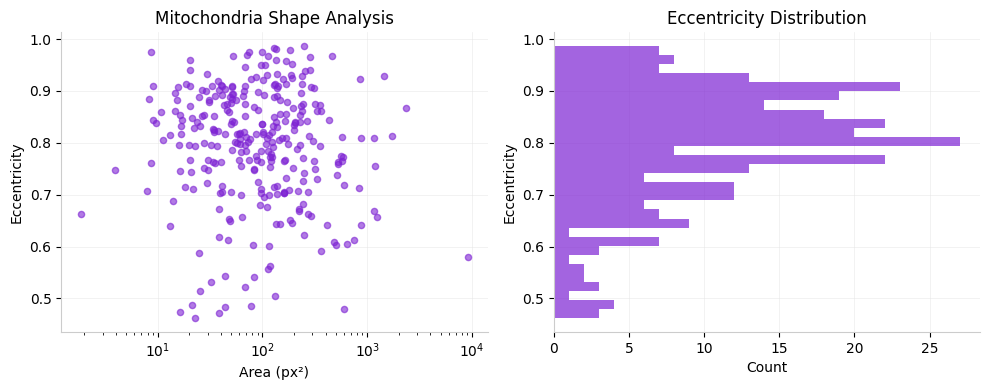

In [9]:
# Plot shape analysis
plot_shape_analysis(df_mito, feature_name='mitochondria')

findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat'

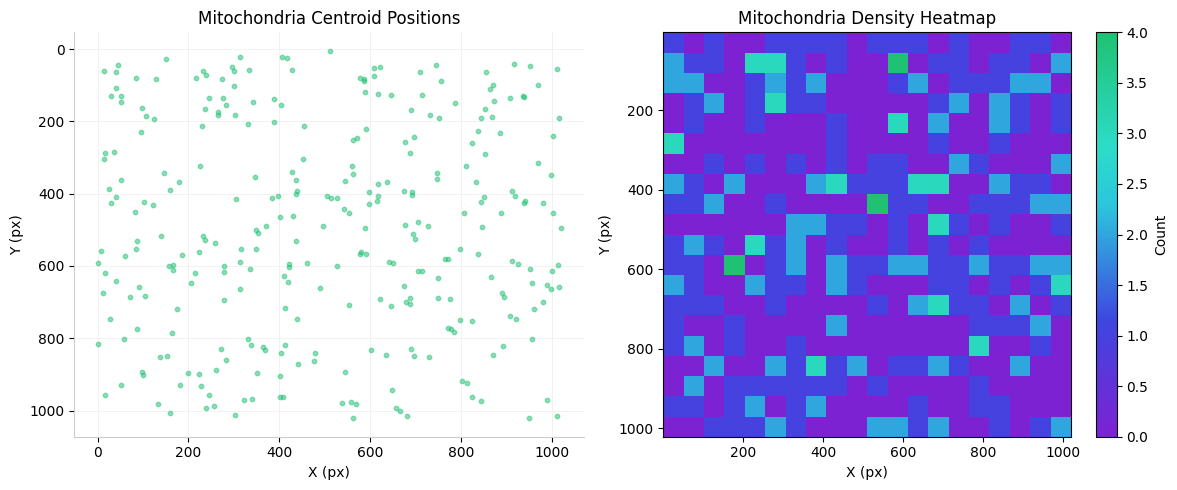

In [10]:
# Plot spatial distribution
plot_spatial_distribution(df_mito, feature_name='mitochondria')

### Example 2: Comparative Analysis

In [11]:
# Generate two datasets for comparison
df1 = generate_dummy_metrics('mitochondria', n_objects=500, seed=42)
df2 = generate_dummy_metrics('mitochondria', n_objects=220, seed=99)

# Adjust mean intensity to create difference
df1['mean_intensity'] = df1['mean_intensity'] - 10
df2['mean_intensity'] = df2['mean_intensity'] + 10

labels = ['Sample A', 'Sample B']

print(f"Sample A: {len(df1)} objects")
print(f"Sample B: {len(df2)} objects")

Sample A: 500 objects
Sample B: 220 objects


findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat'

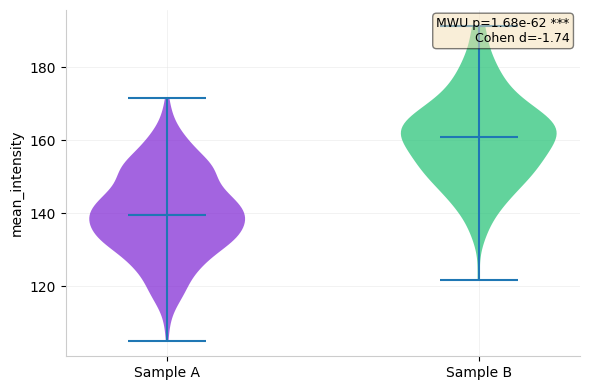

In [12]:
# Compare with violin plots
plot_violin_for_metric([df1, df2], labels=labels, metric='mean_intensity', show_stats=True)

findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat'

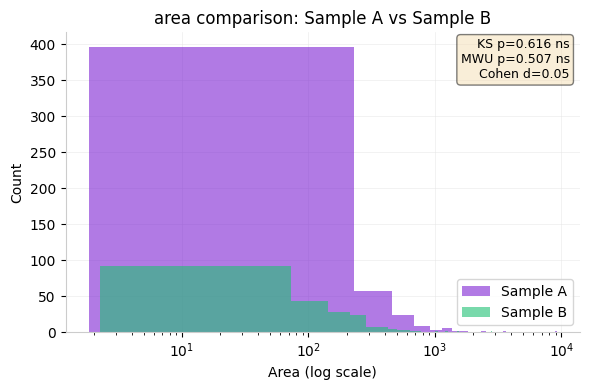

In [13]:
# Compare with overlaid histograms
plot_histograms_metric_for_two_dfs(df1, df2, labels=labels, metric='area', bins=40, show_stats=True)

### Example 3: Multi-Feature Overview

In [14]:
# Generate data for all three feature types
df_mito = generate_dummy_metrics('mitochondria', n_objects=300, seed=42)
df_nuclei = generate_dummy_metrics('nuclei', n_objects=150, seed=43)
df_membrane = generate_dummy_metrics('membrane', n_objects=250, seed=44)

features = [
    ('mitochondria', df_mito),
    ('nuclei', df_nuclei),
    ('membrane', df_membrane)
]

print("Generated data for all features:")
for name, df in features:
    print(f"  {name.capitalize()}: {len(df)} objects")

Generated data for all features:
  Mitochondria: 300 objects
  Nuclei: 150 objects
  Membrane: 250 objects


findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat'

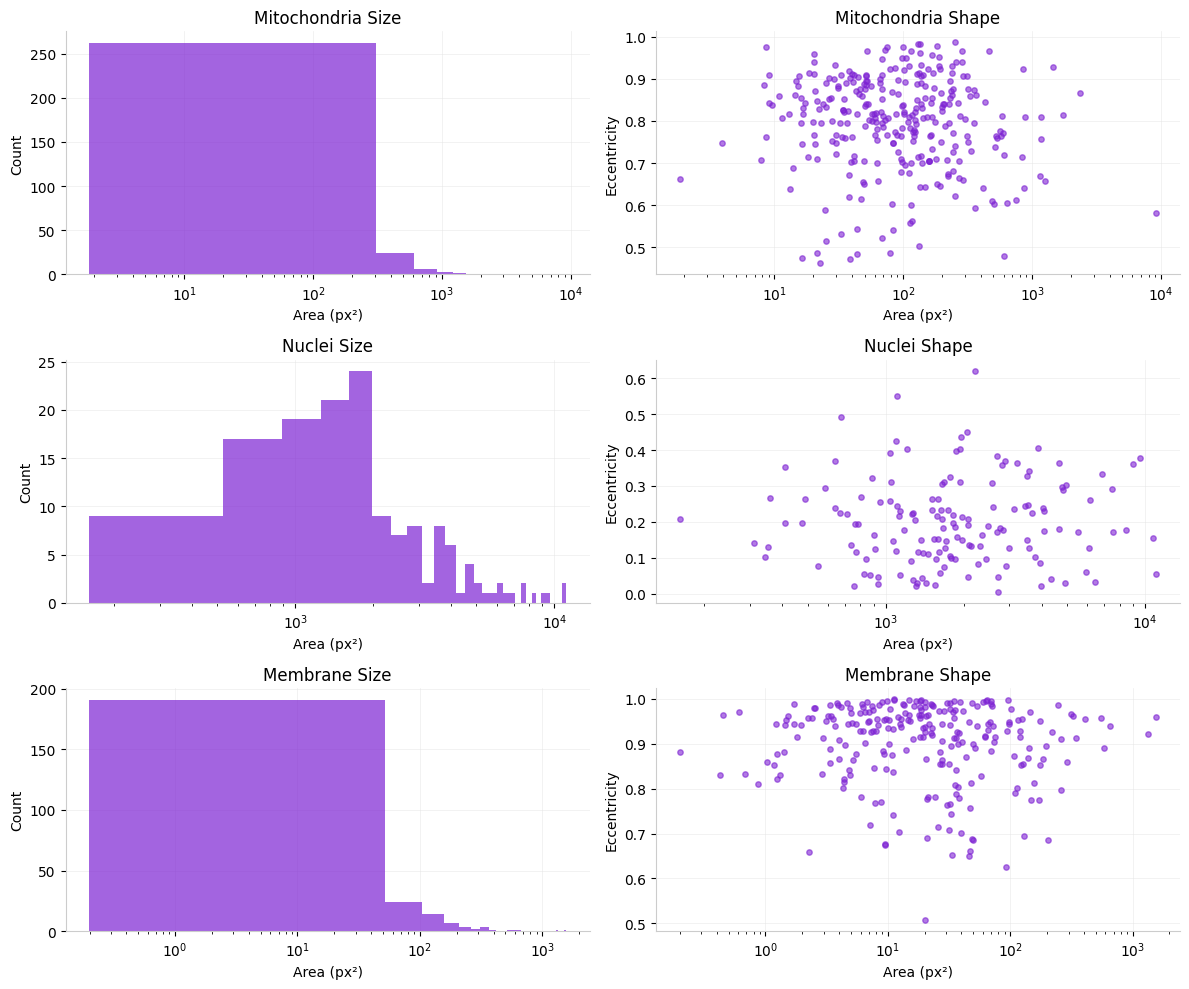

In [15]:
# Create multi-panel overview
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

for i, (name, df) in enumerate(features):
    # Histogram
    axes[i, 0].hist(df['area'], bins=30, color=COLOR_PRIMARY, alpha=0.7)
    axes[i, 0].set_xlabel('Area (px²)')
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].set_xscale('log')
    axes[i, 0].set_title(f'{name.capitalize()} Size')
    style_plot(axes[i, 0])
    
    # Scatter
    axes[i, 1].scatter(df['area'], df['eccentricity'], alpha=0.6, s=15, color=COLOR_PRIMARY)
    axes[i, 1].set_xlabel('Area (px²)')
    axes[i, 1].set_ylabel('Eccentricity')
    axes[i, 1].set_xscale('log')
    axes[i, 1].set_title(f'{name.capitalize()} Shape')
    style_plot(axes[i, 1])

plt.tight_layout()
plt.show()

### Example 4: Save Outputs

In [16]:
# Create outputs directory
os.makedirs('outputs', exist_ok=True)

# Generate and save plots
df_test = generate_dummy_metrics('mitochondria', n_objects=200, seed=50)

saved_files = []

# Save size distribution
png = plot_size_distribution(df_test, feature_name='mitochondria', return_png=True)
if png:
    path = 'outputs/size_distribution.png'
    with open(path, 'wb') as f:
        f.write(png)
    saved_files.append(path)

# Save shape analysis
png = plot_shape_analysis(df_test, feature_name='mitochondria', return_png=True)
if png:
    path = 'outputs/shape_analysis.png'
    with open(path, 'wb') as f:
        f.write(png)
    saved_files.append(path)

# Save spatial distribution
png = plot_spatial_distribution(df_test, feature_name='mitochondria', return_png=True)
if png:
    path = 'outputs/spatial_distribution.png'
    with open(path, 'wb') as f:
        f.write(png)
    saved_files.append(path)

# Save metrics CSV
csv_path = 'outputs/metrics.csv'
df_test.to_csv(csv_path, index=False)
saved_files.append(csv_path)

print(f"✓ Saved {len(saved_files)} files to ./outputs/")
for f in saved_files:
    print(f"  - {f}")

findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat' not found.
findfont: Font family 'Montserrat'

✓ Saved 4 files to ./outputs/
  - outputs/size_distribution.png
  - outputs/shape_analysis.png
  - outputs/spatial_distribution.png
  - outputs/metrics.csv
